In [9]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import cv2
import detectron2
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os, random
import pandas as pd
import torch

In [2]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [3]:
def basketball_dataset_function(dataset_type):
    list_dicts = []
    f = open(f'dataset/anno_{dataset_type}.json')
    data = json.load(f)
    for image_id, filename in enumerate(data):
        img = cv2.imread(f'dataset/images_{dataset_type}/{filename}')
        metadata_dict = {}
        metadata_dict['file_name'] = f'dataset/images_{dataset_type}/{filename}'
        metadata_dict['width'] = img.shape[1]
        metadata_dict['height'] = img.shape[0]
        metadata_dict['image_id'] = image_id
        metadata_dict['annotations'] = []
        
        for player in data[filename]:
            x, y, w, h = data[filename][player]['box']
            x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
            metadata_dict['annotations'].append(
                 {
                  'bbox': [x, y, w, h],
                  'bbox_mode': BoxMode.XYWH_ABS,
                  'category_id': data[filename][player]['team'],
                 }
             )
        list_dicts.append(metadata_dict)
    return list_dicts

In [4]:
for d in ["train", "test"]:
    DatasetCatalog.register("basketball_dataset_" + d, lambda d=d: basketball_dataset_function(d))
    MetadataCatalog.get("basketball_dataset_" + d).set(thing_classes=["team1", "team2"])
basketball_metadata = MetadataCatalog.get("basketball_dataset_train")

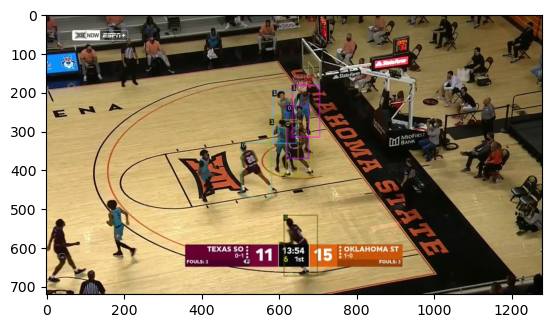

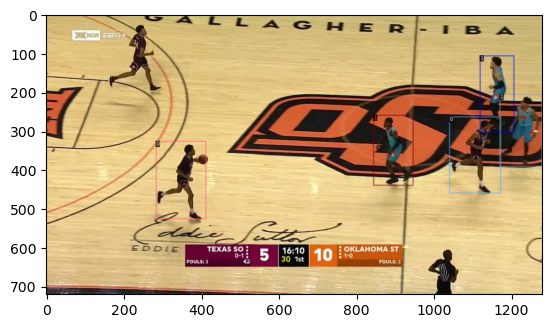

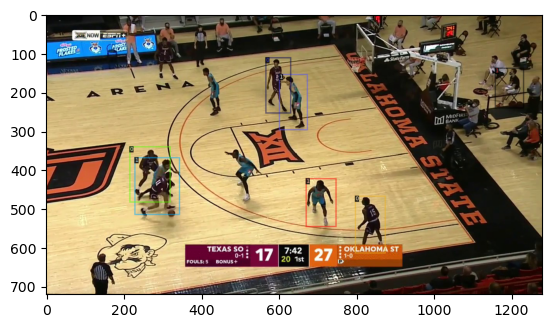

In [5]:
dataset_dicts = basketball_dataset_function('train')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

In [7]:
cfg = get_cfg()
cfg.DATASETS.TRAIN = ("basketball_dataset_train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001 
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[01/05 17:49:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[01/05 17:49:12 d2.data.build]: Removed 0 images with no usable annotations. 400 images left.
[01/05 17:49:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800,), max_size=1333, sample_style='choice'), RandomFlip()]
[01/05 17:49:12 d2.data.build]: Using training sampler TrainingSampler
[01/05 17:49:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[01/05 17:49:12 d2.data.common]: Serializing 400 elements to byte tensors and concatenating them all ...
[01/05 17:49:12 d2.data.common]: Serialized dataset takes 0.14 MiB
WARNING [01/05 17:49:12 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (8, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

In [8]:
trainer.train()

[01/05 00:07:04 d2.engine.train_loop]: Starting training from iteration 0


/home/yaroslav/anaconda3/envs/cv-env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/05 00:07:11 d2.utils.events]:  eta: 0:04:51  iter: 19  total_loss: 1.564  loss_cls: 1.122  loss_box_reg: 0.01213  loss_rpn_cls: 0.376  loss_rpn_loc: 0.03767  time: 0.3000  data_time: 0.0066  lr: 1.9981e-06  max_mem: 4916M
[01/05 00:07:17 d2.utils.events]:  eta: 0:04:44  iter: 39  total_loss: 1.463  loss_cls: 1.04  loss_box_reg: 0.0155  loss_rpn_cls: 0.375  loss_rpn_loc: 0.03895  time: 0.2982  data_time: 0.0023  lr: 3.9961e-06  max_mem: 4916M
[01/05 00:07:23 d2.utils.events]:  eta: 0:04:38  iter: 59  total_loss: 1.255  loss_cls: 0.8121  loss_box_reg: 0.01841  loss_rpn_cls: 0.3654  loss_rpn_loc: 0.03827  time: 0.2978  data_time: 0.0025  lr: 5.9941e-06  max_mem: 4916M
[01/05 00:07:29 d2.utils.events]:  eta: 0:04:32  iter: 79  total_loss: 1.012  loss_cls: 0.589  loss_box_reg: 0.03067  loss_rpn_cls: 0.3642  loss_rpn_loc: 0.04089  time: 0.2962  data_time: 0.0025  lr: 7.9921e-06  max_mem: 4916M
[01/05 00:07:34 d2.utils.events]:  eta: 0:04:25  iter: 99  total_loss: 0.8279  loss_cls: 0.3979

[01/05 00:10:34 d2.utils.events]:  eta: 0:01:12  iter: 739  total_loss: 0.8268  loss_cls: 0.2553  loss_box_reg: 0.4986  loss_rpn_cls: 0.04135  loss_rpn_loc: 0.02441  time: 0.2824  data_time: 0.0024  lr: 7.3926e-05  max_mem: 4916M
[01/05 00:10:40 d2.utils.events]:  eta: 0:01:07  iter: 759  total_loss: 0.842  loss_cls: 0.2426  loss_box_reg: 0.5308  loss_rpn_cls: 0.03766  loss_rpn_loc: 0.026  time: 0.2824  data_time: 0.0026  lr: 7.5924e-05  max_mem: 4916M
[01/05 00:10:46 d2.utils.events]:  eta: 0:01:01  iter: 779  total_loss: 0.8062  loss_cls: 0.2371  loss_box_reg: 0.5059  loss_rpn_cls: 0.04032  loss_rpn_loc: 0.02495  time: 0.2823  data_time: 0.0024  lr: 7.7922e-05  max_mem: 4916M
[01/05 00:10:51 d2.utils.events]:  eta: 0:00:55  iter: 799  total_loss: 0.7591  loss_cls: 0.2157  loss_box_reg: 0.5022  loss_rpn_cls: 0.03434  loss_rpn_loc: 0.02361  time: 0.2822  data_time: 0.0023  lr: 7.992e-05  max_mem: 4916M
[01/05 00:10:57 d2.utils.events]:  eta: 0:00:50  iter: 819  total_loss: 0.761  loss_

In [50]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("basketball_dataset_test", )
predictor = DefaultPredictor(cfg)

[01/05 18:16:30 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weig

In [51]:
test_dataset_dicts = basketball_dataset_function('test')

## Custom MeanIoU

In [158]:
NUM_CLASSES = 2

def mean_iou_score(dataset_dicts, show_rand_image=False):
    sum_of_iou = []
    for d in dataset_dicts:  
        ## Load Image
        img = cv2.imread(d["file_name"])
        # v = Visualizer(img[:, :, ::-1], scale=1)
        zero_img_gt = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
        zero_img_pred = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
        
        ## Calculate preds
        outputs = predictor(img)
        
        for obj in d['annotations']:
            x, y, w, h  = obj['bbox']
            bbox = x, y, x + w, y + h
            # v.draw_box(bbox, edge_color="g", line_style="-", alpha=1,)
            # v.draw_text("GT"+str(obj['category_id']), tuple(bbox[:2]))
            zero_img_gt[y:y+h, x:x+w, obj['category_id']] = 1

        pred_bboxes = outputs["instances"].pred_boxes.to('cpu')
        pred_classes = tuple(outputs["instances"].pred_classes.to('cpu').numpy())
        
        for ind, box in enumerate(pred_bboxes):
            x1, y1, x2, y2 =  tuple(box.numpy().astype(int))
            zero_img_pred[y1:y2, x1:x2, pred_classes[ind]] = 1
            # v.draw_box(box, edge_color="r", line_style="-", alpha=1,)
            # v.draw_text("Pred-" + str(pred_classes[ind]), tuple(box[:2].numpy()))

        counts_array = np.zeros((1, 3))
        for channel in range(zero_img_gt.shape[-1]):
            arr_ = zero_img_gt[:,:, channel] + zero_img_pred[:,:, channel]
            unique, counts = np.unique(arr_, return_counts=True)
            dict_counts_uniq = dict(zip(unique.astype(int), counts))
             
            ## If there is no intersect    
            try:
                counts_array = np.append(counts_array, counts.reshape(1, -1), axis=0)
            except ValueError:
                counts = np.append(counts, 0)
                counts_array = np.append(counts_array, counts.reshape(1, -1), axis=0)
        
        intersect = sum(counts_array[:, 1])
        union = (sum(counts_array[:, 1]) + sum(counts_array[:, 2]))
        
        sum_of_iou.append(intersect / union)
    
    return np.mean(sum_of_iou)

In [159]:
score = mean_iou_score(test_dataset_dicts, show_rand_image=True)
print(score)

0.5701843813265828


## Evaluate mAP

In [98]:
evaluator = COCOEvaluator("basketball_dataset_test", cfg, False, output_dir="./output/")

WARNING [01/05 02:15:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


In [14]:
val_loader = build_detection_test_loader(cfg, "basketball_dataset_test")
inference_on_dataset(predictor.model, val_loader, evaluator)

[01/05 00:12:31 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   team1    | 377          |   team2    | 283          |
|            |              |            |              |
|   total    | 660          |            |              |
[01/05 00:12:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/05 00:12:31 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[01/05 00:12:31 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[01/05 00:12:31 d2.data.common]: Serialized dataset takes 0.04 MiB
[01/05 00:12:31 d2.evaluation.evaluator]: Start inference on 100 batches
[01/05 00:12:32 d2.evaluation.evaluator]: Inference done 11/100. Dataloading: 0.0008 s/

OrderedDict([('bbox',
              {'AP': 27.89442304188876,
               'AP50': 58.17036020392873,
               'AP75': 21.599984286937506,
               'APs': nan,
               'APm': 28.13653528677728,
               'APl': 28.672011506750767,
               'AP-team1': 31.249339992444437,
               'AP-team2': 24.53950609133308})])